# **ML-AI4Econ Course**

We first download the different packages needed for this part of the course:

In [217]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib import colors
from sklearn.inspection import DecisionBoundaryDisplay
import sklearn.datasets as data
from sklearn.linear_model import LinearRegression, QuantileRegressor, Ridge, Lasso, ElasticNet, LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.decomposition import PCA
import scipy.stats as stats
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, median_absolute_error, classification_report, confusion_matrix


We also set a random seed for reproducible results:

In [192]:
np.random.seed(24)

We create some useful functions for later:

In [193]:
def get_coef(model):
    return np.concatenate(([model.intercept_], model.coef_))

def evaluate_model(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    medae = median_absolute_error(y_true, y_pred)
    return mse, rmse, mae, r2, medae


---
### On Prediction Metrics


Before going on, we need to talk about the different metrics that we will use to evaluate whether our model is good enough.

**Mean Squared Error (MSE)**

The Mean Squared Error measures the average of the squared differences between the actual values (\(y_i\)) and the predicted values (\(\hat{y}_i\)). It is defined as:

$$
\text{MSE} = \frac{1}{n} \sum_{i=1}^{n} (y_i - \hat{y}_i)^2
$$

where \(n\) is the number of observations.

**Root Mean Squared Error (RMSE)**

The RMSE is the square root of the MSE, providing an error measure in the same units as the target variable. The formula is:

$$
\text{RMSE} = \sqrt{\frac{1}{n} \sum_{i=1}^{n} (y_i - \hat{y}_i)^2}
$$

**Mean Absolute Error (MAE)**

The Mean Absolute Error calculates the average of the absolute differences between the actual and predicted values:

$$
\text{MAE} = \frac{1}{n} \sum_{i=1}^{n} \left|y_i - \hat{y}_i\right|
$$

This metric is less sensitive to outliers compared to the MSE.

**R-squared ($R^2$)**

The $R^2$ score represents the proportion of variance in the dependent variable that is explained by the model. It is computed as:

$$
R^2 = 1 - \frac{\sum_{i=1}^{n} (y_i - \hat{y}_i)^2}{\sum_{i=1}^{n} (y_i - \bar{y})^2}
$$

where $\bar{y}$ is the mean of the observed values. An $R^2$ value of 1 indicates perfect prediction, whereas a value closer to 0 indicates that the model does not explain much of the variance.

**Median Absolute Error (MedAE)**

The Median Absolute Error is the median of all absolute differences between the predicted and actual values:

$$
\text{MedAE} = \text{median} \left( \left|y_i - \hat{y}_i\right| \right)
$$

This metric provides a robust measure of the typical error, particularly useful when the data contains outliers.


These metrics are used for regression, but we can find different ones for classification tasks as well.

**Accuracy**

Accuracy measures the proportion of correct predictions out of all predictions made. It is defined as:

$$
\text{Accuracy} = \frac{\text{Number of Correct Predictions}}{\text{Total Number of Predictions}}
$$

**Precision**

Precision measures the proportion of true positive predictions out of all positive predictions made by the model. It is defined as:

$$
\text{Precision} = \frac{\text{True Positives}}{\text{True Positives} + \text{False Positives}}
$$

**Recall**

Recall (also known as Sensitivity or True Positive Rate) measures the proportion of actual positives that were correctly identified by the model. It is defined as:

$$
\text{Recall} = \frac{\text{True Positives}}{\text{True Positives} + \text{False Negatives}}
$$

**F1 Score**

The F1 Score is the harmonic mean of precision and recall, providing a balance between the two. It is defined as:

$$
F1 = 2 \times \frac{\text{Precision} \times \text{Recall}}{\text{Precision} + \text{Recall}}
$$

This metric is particularly useful when the class distribution is imbalanced.

---

### Linear Regression

Now that we have seen what multivariate statistics and statistical learning theory can offer, we will go for linear models. The most important ones will be linear regression, logistic regression and LDA. We now start by first importing the data we will use throughout all the notebook, which is the "Boston Housing Prices" dataset, which has different variables related to housing characteristics in Boston and the price of the different houses in the sample.

In [194]:
boston = data.fetch_openml(name="Boston",version=1,as_frame=True)

print("This is our basic dataset information:\n\n",boston.DESCR,"\n")
X = boston.data
print("\nThese are the original explanatory variables:\n\n",X,"\n")
y = boston.target
print("\nThese are the prices for each observation (the target variable):\n\n",y,"\n")

This is our basic dataset information:

 **Author**:   
**Source**: Unknown - Date unknown  
**Please cite**:   

The Boston house-price data of Harrison, D. and Rubinfeld, D.L. 'Hedonic
prices and the demand for clean air', J. Environ. Economics & Management,
vol.5, 81-102, 1978.   Used in Belsley, Kuh & Welsch, 'Regression diagnostics
...', Wiley, 1980.   N.B. Various transformations are used in the table on
pages 244-261 of the latter.
Variables in order:
CRIM     per capita crime rate by town
ZN       proportion of residential land zoned for lots over 25,000 sq.ft.
INDUS    proportion of non-retail business acres per town
CHAS     Charles River dummy variable (= 1 if tract bounds river; 0 otherwise)
NOX      nitric oxides concentration (parts per 10 million)
RM       average number of rooms per dwelling
AGE      proportion of owner-occupied units built prior to 1940
DIS      weighted distances to five Boston employment centres
RAD      index of accessibility to radial highways
TAX 

We can see that there are categorical variables, so we need to do some transformation! We will do so with one-hot encoding, which is basically to include binary variables for all categories but a base one (in this case, the first).

In [195]:
encoder = OneHotEncoder(drop="first")
cat_encoded = encoder.fit_transform(X[["CHAS","RAD"]])
cat_encoded = cat_encoded.toarray()
encoded_columns = encoder.get_feature_names_out(["CHAS", "RAD"])

x_cols = list(X.columns)
x_cols.pop(3)
x_cols.pop(7)
X = X[x_cols]

cat_df = pd.DataFrame(cat_encoded, columns=encoded_columns, index=X.index)
X = pd.concat([X,cat_df],axis=1)
print("\nAfter encoding, these are the variables:\n\n",X,"\n")



After encoding, these are the variables:

         CRIM    ZN  INDUS    NOX     RM   AGE     DIS    TAX  PTRATIO       B  \
0    0.00632  18.0   2.31  0.538  6.575  65.2  4.0900  296.0     15.3  396.90   
1    0.02731   0.0   7.07  0.469  6.421  78.9  4.9671  242.0     17.8  396.90   
2    0.02729   0.0   7.07  0.469  7.185  61.1  4.9671  242.0     17.8  392.83   
3    0.03237   0.0   2.18  0.458  6.998  45.8  6.0622  222.0     18.7  394.63   
4    0.06905   0.0   2.18  0.458  7.147  54.2  6.0622  222.0     18.7  396.90   
..       ...   ...    ...    ...    ...   ...     ...    ...      ...     ...   
501  0.06263   0.0  11.93  0.573  6.593  69.1  2.4786  273.0     21.0  391.99   
502  0.04527   0.0  11.93  0.573  6.120  76.7  2.2875  273.0     21.0  396.90   
503  0.06076   0.0  11.93  0.573  6.976  91.0  2.1675  273.0     21.0  396.90   
504  0.10959   0.0  11.93  0.573  6.794  89.3  2.3889  273.0     21.0  393.45   
505  0.04741   0.0  11.93  0.573  6.030  80.8  2.5050  273.0     

Because we are interested in prediction, let us divide the dataset into train and test samples:

In [196]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Now that we have the data, we focus first on the simple multivariate regression model. We try estimating different linear regression models, first starting with the most basic one.

In [197]:
lin_reg = LinearRegression(n_jobs=2)  # We create first the object that will allow us to create the regression
lin_reg.fit(X_train,y_train) # fit the model through L2

coef = lin_reg.coef_ # get coefficients
intercept = lin_reg.intercept_ # get intercept

X_design = np.hstack([np.ones((X_train.shape[0], 1)), X_train.values]) # obtains the matrix with a column of ones
p = X_design.shape[1] # obtain number of variables
n = X_design.shape[0] # obtains number of observations

y_pred = lin_reg.predict(X=X_train) # get predictions for each X in the sample
residuals = y_train - y_pred # obtain residuals

sigma2 = np.sum(residuals**2) / (n - p) # compute variance

XtX_inv = np.linalg.inv(X_design.T @ X_design) # compute standard errors through formula
std_errors = np.sqrt(sigma2 * np.diag(XtX_inv))

t_stats = np.concatenate(([intercept], coef)) / std_errors
p_values = 2 * (1 - stats.t.cdf(np.abs(t_stats), df=(n - p)))

param_names = get_coef(lin_reg)
results_ols = pd.DataFrame({
    'Coefficient': np.concatenate(([intercept], coef)),
    'Std_Error': std_errors,
    't_stat': t_stats,
    'p_value': p_values
}, index=param_names) # create dataframe to visualize parameters

print("L2 Loss Model (Ordinary Least Squares) results:\n")
print(results_ols)

L2 Loss Model (Ordinary Least Squares) results:

            Coefficient  Std_Error    t_stat       p_value
 28.922427    28.922427   6.044107  4.785228  2.442534e-06
-0.115144     -0.115144   0.034454 -3.342009  9.136107e-04
 0.039071      0.039071   0.016311  2.395376  1.708278e-02
 0.057604      0.057604   0.069276  0.831513  4.062019e-01
-17.976203   -17.976203   4.368049 -4.115385  4.735728e-05
 4.287261      4.287261   0.467228  9.175953  0.000000e+00
-0.007612     -0.007612   0.014567 -0.522527  6.016059e-01
-1.533579     -1.533579   0.228188 -6.720677  6.575118e-11
-0.006297     -0.006297   0.004381 -1.437328  1.514412e-01
-0.904099     -0.904099   0.158362 -5.709046  2.280410e-08
 0.012547      0.012547   0.002926  4.288875  2.276159e-05
-0.508581     -0.508581   0.055383 -9.183055  0.000000e+00
 2.586673      2.586673   0.950503  2.721372  6.797848e-03
 1.073336      1.073336   1.579756  0.679431  4.972751e-01
 5.876271      5.876271   2.017437  2.912740  3.792628e-03
 4.7213

Let us see what happens when we change the loss function to an L1:

In [198]:
l1_reg = QuantileRegressor(quantile=0.5, alpha=0, solver='highs')
l1_reg.fit(X_train, y_train)
coef_l1 = l1_reg.coef_
intercept_l1 = l1_reg.intercept_

results_l1 = pd.DataFrame({
    'Coefficient': np.concatenate(([intercept_l1], coef_l1))
}, index=param_names)

print("\nL1 Model (Quantile Regression at 0.5) Coefficients results:")
print(results_l1)


L1 Model (Quantile Regression at 0.5) Coefficients results:
            Coefficient
 28.922427    13.775192
-0.115144     -0.120776
 0.039071      0.026345
 0.057604      0.002461
-17.976203    -9.585779
 4.287261      5.251115
-0.007612     -0.035036
-1.533579     -1.110004
-0.006297     -0.003979
-0.904099     -0.778151
 0.012547      0.012885
-0.508581     -0.272514
 2.586673      1.118469
 1.073336      1.713233
 5.876271      2.322142
 4.721367      3.598270
 1.800290      1.152961
 2.680476      1.418405
 0.387312     -0.417580
 4.349435      2.898910
 4.138775      3.145907


When we compute the L1 loss results, there is no closed formula for the coefficients, and we cannot derive the standard deviation of our coefficients. What can we do? Are we gonna be happy with just some numbers?

In this case, we can use a great statistical sampling mechanism that allows us to study variability with relatively small datasets and which is fundamental for many machine learning algorithms: we will use **bootstrap** for obtaining the variance of our coefficients.

In [199]:
B = 1000 # number of boostrap iterations
n = X_train.shape[0] # number of obs

param_names = ['Intercept'] + list(X_train.columns)
p = len(param_names) # number of variables
coefs_bootstrap = np.zeros((B, p)) # create a matrix to save results!

for b in range(B):
    indices = np.random.choice(n, n, replace=True) # sample indices with replacement
    X_boot = X.iloc[indices] # obtain the values of the variables for the group of indices
    y_boot = y.iloc[indices]
    
    model_boot = QuantileRegressor(quantile=0.5, alpha=0, solver='highs')
    model_boot.fit(X_boot, y_boot) # we fit the model with these values
    
    coef_boot = np.concatenate(([model_boot.intercept_], model_boot.coef_)) # combine coefficients
    coefs_bootstrap[b, :] = coef_boot

std_errors_boot = np.std(coefs_bootstrap, axis=0)  # compute the standard error

l1_reg = QuantileRegressor(quantile=0.5, alpha=0, solver='highs')
l1_reg.fit(X_train, y_train)
coef_l1 = np.concatenate(([l1_reg.intercept_], l1_reg.coef_))

t_stats_l1 = coef_l1 / std_errors_boot
p_values_l1 = 2 * (1 - stats.norm.cdf(np.abs(t_stats_l1)))

results_l1_boot = pd.DataFrame({
    'Coefficient': coef_l1,
    'Bootstrap_Std_Error': std_errors_boot,
    't_stat': t_stats_l1,
    'p_value': p_values_l1
}, index=param_names)

print("=== L1 Model (Quantile Regression) with Bootstrap Inference ===")
print(results_l1_boot)

=== L1 Model (Quantile Regression) with Bootstrap Inference ===
           Coefficient  Bootstrap_Std_Error    t_stat       p_value
Intercept    13.775192             9.366544  1.470680  1.413776e-01
CRIM         -0.120776             0.115141 -1.048947  2.942027e-01
ZN            0.026345             0.015764  1.671184  9.468542e-02
INDUS         0.002461             0.051259  0.048010  9.617084e-01
NOX          -9.585779             4.487410 -2.136150  3.266722e-02
RM            5.251115             0.978819  5.364745  8.106369e-08
AGE          -0.035036             0.015794 -2.218265  2.653674e-02
DIS          -1.110004             0.211649 -5.244560  1.566557e-07
TAX          -0.003979             0.003489 -1.140173  2.542141e-01
PTRATIO      -0.778151             0.111101 -7.004025  2.487122e-12
B             0.012885             0.007808  1.650301  9.888146e-02
LSTAT        -0.272514             0.089402 -3.048209  2.302099e-03
CHAS_1        1.118469             0.898273  1.24513

Even though we cannot plot the models, let us compare the coefficients visually:

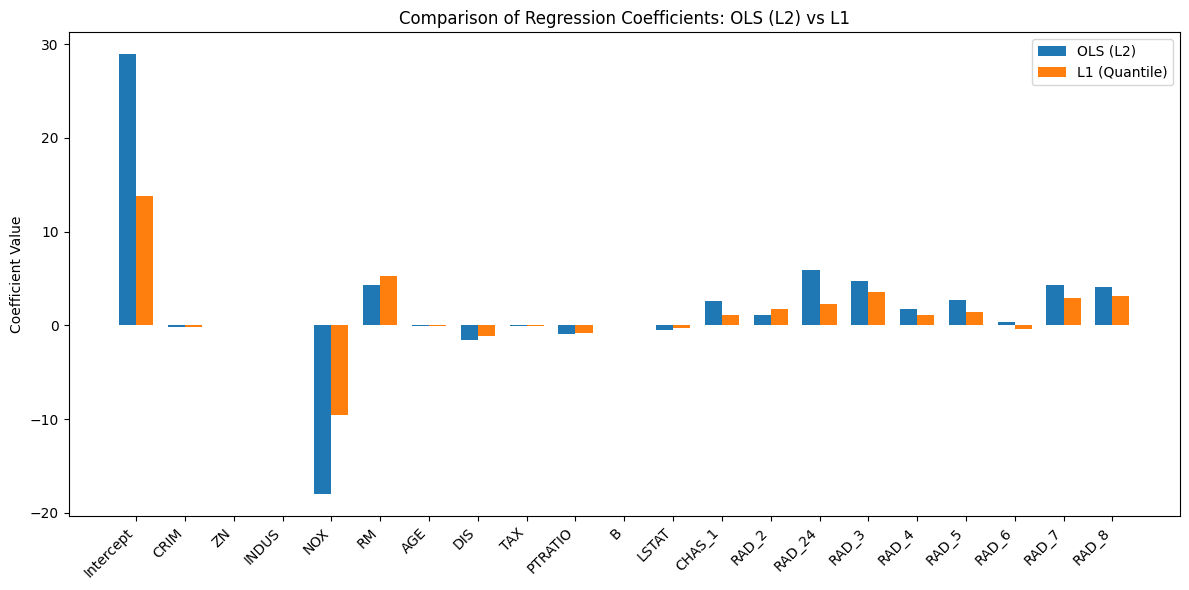

In [200]:
fig, ax = plt.subplots(figsize=(12, 6))
x = np.arange(len(param_names))
width = 0.35

ax.bar(x - width/2, results_ols['Coefficient'], width, label='OLS (L2)')
ax.bar(x + width/2, results_l1['Coefficient'], width, label='L1 (Quantile)')

ax.set_xticks(x)
ax.set_xticklabels(param_names, rotation=45, ha="right")
ax.set_ylabel("Coefficient Value")
ax.set_title("Comparison of Regression Coefficients: OLS (L2) vs L1")
ax.legend()
plt.tight_layout()
plt.show()

Finally, we want to test the generalization ability of our model:


Evaluation Metrics on Test Set:

      Metric        OLS         L1
0        MSE  24.818443  27.744833
1       RMSE   4.981811   5.267336
2        MAE   3.307085   3.105236
3         R2   0.661569   0.621664
4  Median AE   2.561279   1.928401 



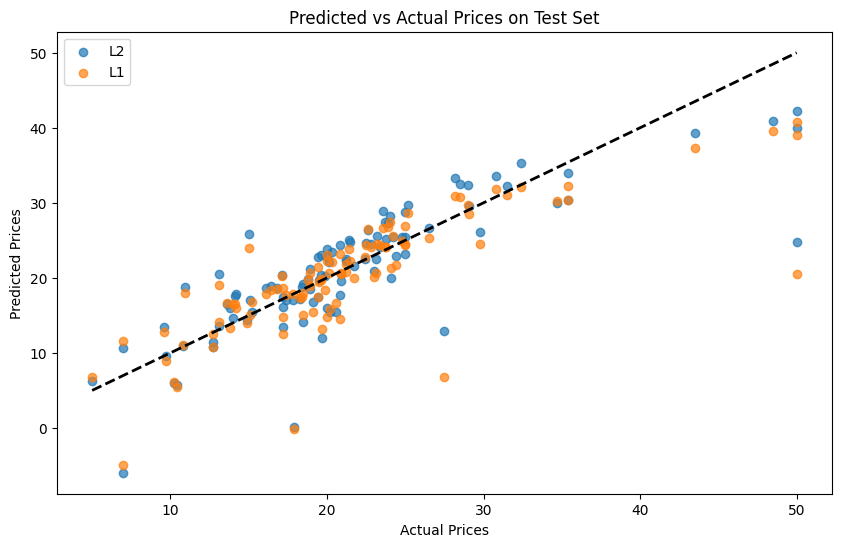

In [201]:
y_pred_test_ols = lin_reg.predict(X_test)
y_pred_test_l1 = l1_reg.predict(X_test)

metrics_ols = evaluate_model(y_test, y_pred_test_ols)
metrics_l1 = evaluate_model(y_test, y_pred_test_l1)

metrics_df = pd.DataFrame({
    'Metric': ['MSE', 'RMSE', 'MAE', 'R2', 'Median AE'],
    'OLS': metrics_ols,
    'L1': metrics_l1
})
print("\nEvaluation Metrics on Test Set:\n")
print(metrics_df,"\n")

# Plot Actual vs Predicted

plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred_test_ols, label='L2', alpha=0.7)
plt.scatter(y_test, y_pred_test_l1, label='L1', alpha=0.7)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
plt.xlabel("Actual Prices")
plt.ylabel("Predicted Prices")
plt.title("Predicted vs Actual Prices on Test Set")
plt.legend()
plt.show()

Are we able to improve these results by regularizing the models? Let us try now! In this exercise we will use different regularization techniques to compare the results with the ones obtained before. First, we estimate the new models and then we do a similar procedure.

In [202]:
ridge_model = Ridge(alpha=1.0, random_state=42)  # L2 regularization
ridge_model.fit(X_train, y_train)

lasso_model = Lasso(alpha=0.1, random_state=42, max_iter=10000)  # L1 regularization
lasso_model.fit(X_train, y_train)

elastic_model = ElasticNet(alpha=0.1, l1_ratio=0.5, random_state=42, max_iter=10000)
elastic_model.fit(X_train, y_train)

coef_ols = get_coef(lin_reg)
coef_ridge = get_coef(ridge_model)
coef_lasso = get_coef(lasso_model)
coef_elastic = get_coef(elastic_model)

coef_df = pd.DataFrame({
    'OLS': coef_ols,
    'Ridge': coef_ridge,
    'Lasso': coef_lasso,
    'ElasticNet': coef_elastic
}, index=param_names)

print("\nCoefficients from Different Models:\n")
print(coef_df)


Coefficients from Different Models:

                 OLS      Ridge      Lasso  ElasticNet
Intercept  28.922427  24.313279  15.514882   21.278462
CRIM       -0.115144  -0.108163  -0.079207   -0.085673
ZN          0.039071   0.037633   0.028244    0.031387
INDUS       0.057604   0.014328  -0.049073   -0.058770
NOX       -17.976203  -9.554143  -0.000000   -0.000000
RM          4.287261   4.326043   4.532478    3.880240
AGE        -0.007612  -0.014066  -0.016250   -0.013835
DIS        -1.533579  -1.416468  -1.152537   -1.192076
TAX        -0.006297  -0.005764  -0.001421   -0.002713
PTRATIO    -0.904099  -0.834735  -0.681611   -0.710915
B           0.012547   0.012706   0.012463    0.012238
LSTAT      -0.508581  -0.524810  -0.554954   -0.592472
CHAS_1      2.586673   2.390368   1.203524    1.098596
RAD_2       1.073336   0.473048  -0.000000   -0.000000
RAD_24      5.876271   4.068254   0.000000    0.579234
RAD_3       4.721367   3.792508   1.560490    1.245086
RAD_4       1.800290   0.88

Let us take a look at the coefficients through a visual comparison:

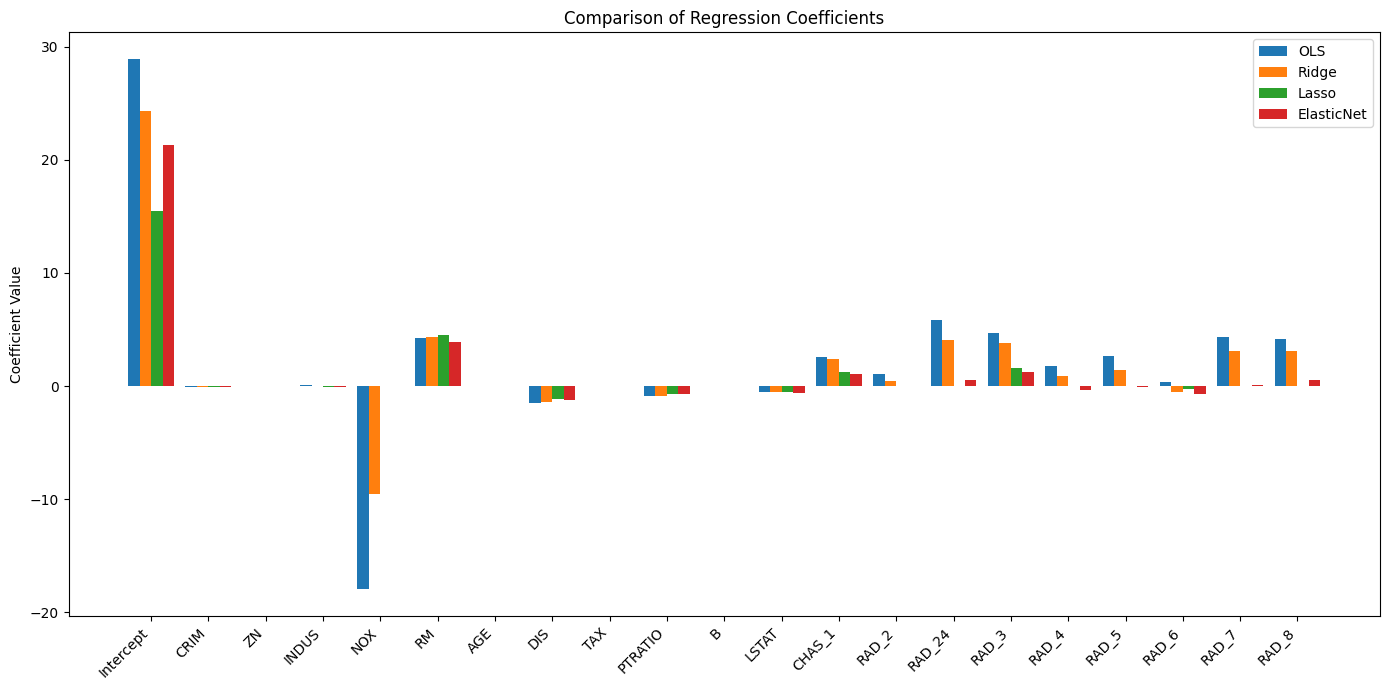

In [203]:
x = np.arange(len(param_names))  # one position for each parameter
width = 0.2  # width for each bar

fig, ax = plt.subplots(figsize=(14, 7))
ax.bar(x - 1.5*width, coef_df['OLS'], width, label='OLS')
ax.bar(x - 0.5*width, coef_df['Ridge'], width, label='Ridge')
ax.bar(x + 0.5*width, coef_df['Lasso'], width, label='Lasso')
ax.bar(x + 1.5*width, coef_df['ElasticNet'], width, label='ElasticNet')

ax.set_xticks(x)
ax.set_xticklabels(param_names, rotation=45, ha='right')
ax.set_ylabel("Coefficient Value")
ax.set_title("Comparison of Regression Coefficients")
ax.legend()
plt.tight_layout()
plt.show()

Finally, how did our regularized models do?


=== Evaluation Metrics on Test Set ===
      Metric        OLS      Ridge      Lasso  ElasticNet
0        MSE  24.818443  25.131033  26.996344   26.004773
1       RMSE   4.981811   5.013086   5.195801    5.099488
2        MAE   3.307085   3.256083   3.300217    3.260445
3         R2   0.661569   0.657306   0.631870    0.645392
4  Median AE   2.561279   2.276976   2.122571    2.148517 



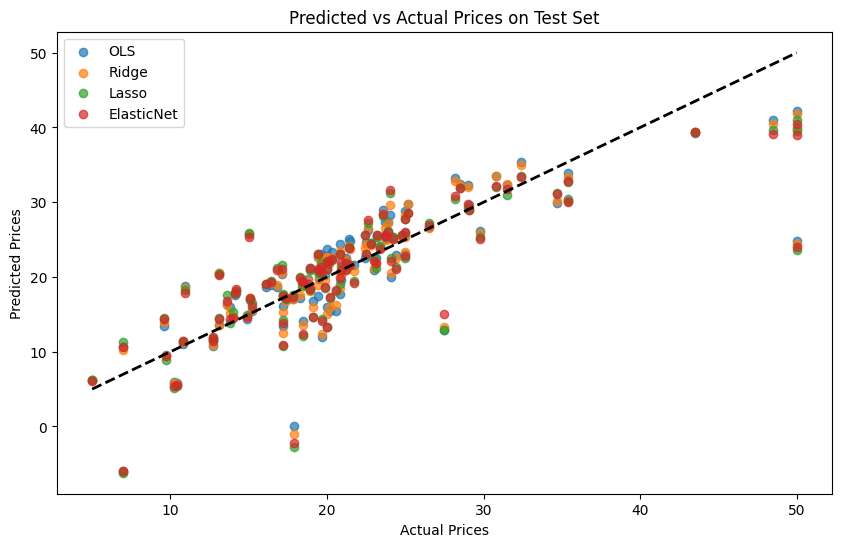

In [204]:
y_pred_ols = lin_reg.predict(X_test)
y_pred_ridge = ridge_model.predict(X_test)
y_pred_lasso = lasso_model.predict(X_test)
y_pred_elastic = elastic_model.predict(X_test)

metrics_ols = evaluate_model(y_test, y_pred_ols)
metrics_ridge = evaluate_model(y_test, y_pred_ridge)
metrics_lasso = evaluate_model(y_test, y_pred_lasso)
metrics_elastic = evaluate_model(y_test, y_pred_elastic)

metrics_df = pd.DataFrame({
    'Metric': ['MSE', 'RMSE', 'MAE', 'R2', 'Median AE'],
    'OLS': metrics_ols,
    'Ridge': metrics_ridge,
    'Lasso': metrics_lasso,
    'ElasticNet': metrics_elastic
})
print("\n=== Evaluation Metrics on Test Set ===")
print(metrics_df,"\n")

# Plot of Actual vs Predicted

plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred_ols, label='OLS', alpha=0.7)
plt.scatter(y_test, y_pred_ridge, label='Ridge', alpha=0.7)
plt.scatter(y_test, y_pred_lasso, label='Lasso', alpha=0.7)
plt.scatter(y_test, y_pred_elastic, label='ElasticNet', alpha=0.7)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
plt.xlabel("Actual Prices")
plt.ylabel("Predicted Prices")
plt.title("Predicted vs Actual Prices on Test Set")
plt.legend()
plt.show()

Is there anything we can still do to get a good generalization, apart from changing the loss function we estimate the model with? Yes. We can still try to find a better model by using a technique called **cross-validation** for **hyperparameter tuning**. This will allow us to obtain a "best" model for our regularized models and assess whether our generalization ability was good enouigh even before testing the data.

---

### On Cross-validation

Cross validation involves partitioning the dataset into several folds. In each iteration, one fold is used as the test set while the remaining folds are used for training. This process is repeated until each fold has served as the test set exactly once. Some common types of cross-validation are the following:

- **K-Fold Cross Validation:**  
  The data is divided into K equal parts (folds). The model is trained K times, each time leaving out one of the folds as the test set. The performance is then averaged over the K iterations.

- **Leave-One-Out Cross Validation (LOOCV):**  
  A special case of K-Fold where K is equal to the number of observations. Each observation is used once as the test set, while the remaining observations form the training set.

- **Stratified K-Fold Cross Validation:**  
  Used mainly for classification, this method ensures that each fold has approximately the same percentage of samples of each target class as the complete dataset.

Cross validation provides a more reliable estimate of model performance compared to a single train/test split, and also allows choosing between hyperparameters. It reduces the risk of overfitting and ensures that the model's evaluation is not dependent on one particular split of the data. The practical process would be the following:

1. Divide the dataset into K folds.
2. For each fold:
   - Train the model on the remaining K-1 folds.
   - Test the model on the current fold.
3. Calculate the performance metric for each fold.
4. Average the metrics across all folds to obtain the final performance measure.
5. If the model has hyperparameters

---

In [205]:
ridge_metrics = evaluate_model(y_test, y_pred_ridge)
lasso_metrics = evaluate_model(y_test, y_pred_lasso)

ridge_params = {'alpha': [0.01, 0.1, 1.0, 10.0, 100.0]}
lasso_params = {'alpha': [0.001, 0.01, 0.1, 1.0, 10.0]}

ridge_cv = GridSearchCV(Ridge(random_state=42), ridge_params, cv=5, scoring='neg_mean_squared_error')
ridge_cv.fit(X_train, y_train)
best_ridge = ridge_cv.best_estimator_

mean_train_score = -ridge_cv.cv_results_["mean_test_score"][ridge_cv.best_index_]
print("Mean Training MSE from CV (Ridge): {:.4f}".format(mean_train_score),"\n\n")

lasso_cv = GridSearchCV(Lasso(random_state=42), lasso_params, cv=5, scoring='neg_mean_squared_error')
lasso_cv.fit(X_train, y_train)
best_lasso = lasso_cv.best_estimator_

mean_train_score = -lasso_cv.cv_results_["mean_test_score"][lasso_cv.best_index_]
print("Mean Training MSE from CV (Lasso): {:.4f}".format(mean_train_score),"\n\n")

best_ridge_pred = best_ridge.predict(X_test)
best_lasso_pred = best_lasso.predict(X_test)

best_ridge_metrics = evaluate_model(y_test, best_ridge_pred)
best_lasso_metrics = evaluate_model(y_test, best_lasso_pred)

models = [
    'Ridge (default)',
    'Lasso (default)',
    'Ridge (CV tuned)',
    'Lasso (CV tuned)'
]

mse_values = [
    ridge_metrics[0],
    lasso_metrics[0],
    best_ridge_metrics[0],
    best_lasso_metrics[0],
]

mae_values = [
    ridge_metrics[2],
    lasso_metrics[2],
    best_ridge_metrics[2],
    best_lasso_metrics[2]
]

r2_values = [
    ridge_metrics[3],
    lasso_metrics[3],
    best_ridge_metrics[3],
    best_lasso_metrics[3]
]

results_df = pd.DataFrame({
    'Model': models,
    'MSE': mse_values,
    'MAE': mae_values,
    'R2': r2_values
})

print("Test Set Performance Comparison:\n")
print(results_df)

Mean Training MSE from CV (Ridge): 23.0009 


Mean Training MSE from CV (Lasso): 23.0042 


Test Set Performance Comparison:

              Model        MSE       MAE        R2
0   Ridge (default)  25.131033  3.256083  0.657306
1   Lasso (default)  26.996344  3.300217  0.631870
2  Ridge (CV tuned)  24.818800  3.305984  0.661564
3  Lasso (CV tuned)  24.859569  3.308192  0.661008


Graphically, we can spot the changes that happened here:

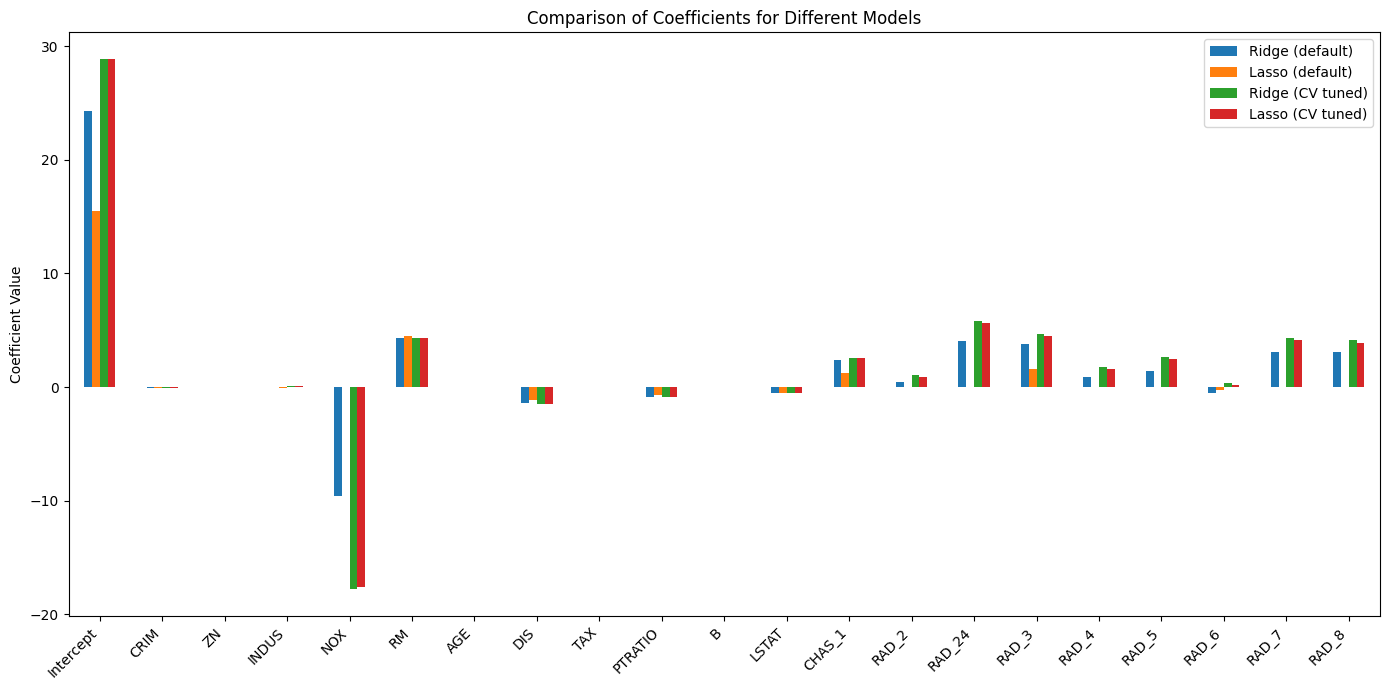

In [206]:
coef_ridge_cv = get_coef(best_ridge)
coef_lasso_cv = get_coef(best_lasso)

coef_df = pd.DataFrame({
    'Ridge (default)': coef_ridge,
    'Lasso (default)': coef_lasso,
    'Ridge (CV tuned)': coef_ridge_cv,
    'Lasso (CV tuned)': coef_lasso_cv
}, index=['Intercept'] + list(X_train.columns))

coef_df.plot(kind='bar', figsize=(14,7))
plt.ylabel("Coefficient Value")
plt.title("Comparison of Coefficients for Different Models")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

And we can also take a look at the predictions:

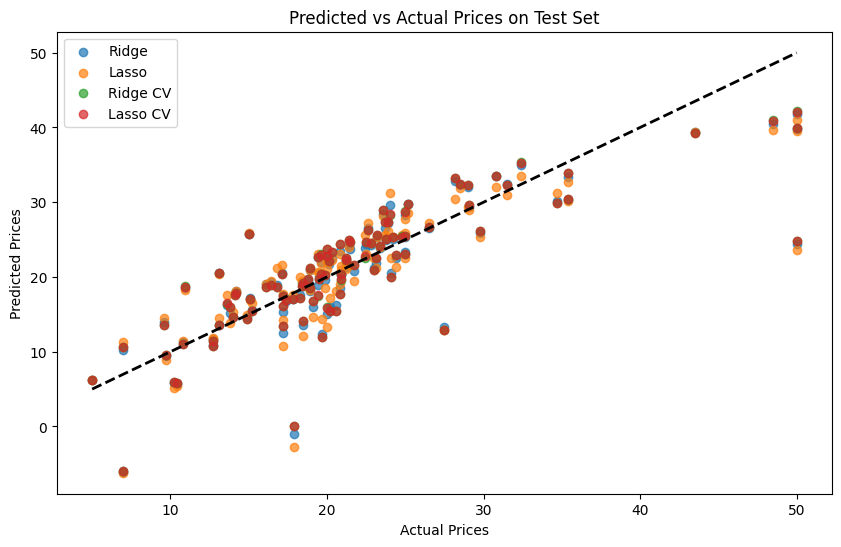

In [207]:
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred_ridge, label='Ridge', alpha=0.7)
plt.scatter(y_test, y_pred_lasso, label='Lasso', alpha=0.7)
plt.scatter(y_test, best_ridge_pred, label='Ridge CV', alpha=0.7)
plt.scatter(y_test, best_lasso_pred, label='Lasso CV', alpha=0.7)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
plt.xlabel("Actual Prices")
plt.ylabel("Predicted Prices")
plt.title("Predicted vs Actual Prices on Test Set")
plt.legend()
plt.show()

We have seen a lot of stuff! In fact, we have seen techniques for **evaluation**, **model selection**, **data transformation** and **regularization**. Therefore, these are now assumed to be known, and we will apply them regularly without the need of comparing different possibilities from now on. We can now continue to linear models for classification.

### Logistic Regression

Now, we want a linear model that can work for classification, given that the linear regression model is not suited for this purpose. One of the best optios is the logistic regression, which basically is a generalized linear model that allows to classify different observations based on the probability given by the model to each of the possible classes or categories. In this case, we will not use the "Boston Housing Prices" dataset, but the "Iris" dataset.

In [208]:
iris = data.fetch_openml(name='iris', version=1, as_frame=True)
iris_desc = load_iris()
X_iris = iris.data
y_iris = iris.target
target_names = iris.target_names

print("This is our basic dataset information:\n\n",iris_desc.DESCR,"\n")
print("Features:\n\n")
print(X_iris)
print("\n\nTarget:\n\n")
print(y_iris)

This is our basic dataset information:

 .. _iris_dataset:

Iris plants dataset
--------------------

**Data Set Characteristics:**

:Number of Instances: 150 (50 in each of three classes)
:Number of Attributes: 4 numeric, predictive attributes and the class
:Attribute Information:
    - sepal length in cm
    - sepal width in cm
    - petal length in cm
    - petal width in cm
    - class:
            - Iris-Setosa
            - Iris-Versicolour
            - Iris-Virginica

:Summary Statistics:

============== ==== ==== ======= ===== ====================
                Min  Max   Mean    SD   Class Correlation
============== ==== ==== ======= ===== ====================
sepal length:   4.3  7.9   5.84   0.83    0.7826
sepal width:    2.0  4.4   3.05   0.43   -0.4194
petal length:   1.0  6.9   3.76   1.76    0.9490  (high!)
petal width:    0.1  2.5   1.20   0.76    0.9565  (high!)
============== ==== ==== ======= ===== ====================

:Missing Attribute Values: None
:Class Distr

We now divide train and test data:

In [209]:
X_train, X_test, y_train, y_test = train_test_split(X_iris, y_iris, test_size=0.2, random_state=42)

Now, we estimate our logistic regression model with our train data and evaluate the performance of our model:

In [210]:
logreg = LogisticRegression(max_iter=1000, random_state=42)
logreg.fit(X_train, y_train)

y_pred = logreg.predict(X_test)

# Evaluate the model using classification report and confusion matrix

print("\nClassification Report:\n\n")
print(classification_report(y_test, y_pred),"\n")
print("\nConfusion Matrix:\n\n")
print(confusion_matrix(y_test, y_pred))


Classification Report:


                 precision    recall  f1-score   support

    Iris-setosa       1.00      1.00      1.00        10
Iris-versicolor       1.00      1.00      1.00         9
 Iris-virginica       1.00      1.00      1.00        11

       accuracy                           1.00        30
      macro avg       1.00      1.00      1.00        30
   weighted avg       1.00      1.00      1.00        30
 


Confusion Matrix:


[[10  0  0]
 [ 0  9  0]
 [ 0  0 11]]


We can take a look at how we are assigning each observation to a group.

In [211]:
probabilities = logreg.predict_proba(X_test)
prob_df = pd.DataFrame(probabilities, columns=[f"Probability(Class {i})" for i in range(probabilities.shape[1])])
print("Predicted class probabilities for some test observations:\n")
print(prob_df.head())

Predicted class probabilities for some test observations:

   Probability(Class 0)  Probability(Class 1)  Probability(Class 2)
0          3.775549e-03              0.826987          1.692376e-01
1          9.471596e-01              0.052840          1.986096e-07
2          8.526963e-09              0.001558          9.984423e-01
3          6.380907e-03              0.792149          2.014703e-01
4          1.433362e-03              0.774122          2.244442e-01


### Linear Discriminant Analysis

A different approach would be to use linear discriminant analysis. In this case, we try to infer some Bayesian decision boundaries from the data among categories to classify different observations, assuming normality, and we play with Bayes Theorem in order to provide a posterior probability of pertaining to one class for each observation.

In [212]:
X_plot = X_iris.iloc[:, 2:4]
X_train, X_test, y_train, y_test = train_test_split(X_plot, y_iris, test_size=0.3, random_state=42)

In [213]:
lda = LinearDiscriminantAnalysis()
qda = QuadraticDiscriminantAnalysis()

lda.fit(X_train, y_train)
qda.fit(X_train, y_train)

y_pred_lda = lda.predict(X_test)
y_pred_qda = qda.predict(X_test)

# Evaluate the model using classification report and confusion matrix

print("\nClassification Report for LDA:\n\n")
print(classification_report(y_test, y_pred_lda),"\n")
print("\nConfusion Matrix for LDA:\n\n")
print(confusion_matrix(y_test, y_pred_lda))

print("\nClassification Report for QDA:\n\n")
print(classification_report(y_test, y_pred_qda),"\n")
print("\nConfusion Matrix for QDA:\n\n")
print(confusion_matrix(y_test, y_pred_qda))


Classification Report for LDA:


                 precision    recall  f1-score   support

    Iris-setosa       1.00      1.00      1.00        19
Iris-versicolor       1.00      1.00      1.00        13
 Iris-virginica       1.00      1.00      1.00        13

       accuracy                           1.00        45
      macro avg       1.00      1.00      1.00        45
   weighted avg       1.00      1.00      1.00        45
 


Confusion Matrix for LDA:


[[19  0  0]
 [ 0 13  0]
 [ 0  0 13]]

Classification Report for QDA:


                 precision    recall  f1-score   support

    Iris-setosa       1.00      1.00      1.00        19
Iris-versicolor       1.00      1.00      1.00        13
 Iris-virginica       1.00      1.00      1.00        13

       accuracy                           1.00        45
      macro avg       1.00      1.00      1.00        45
   weighted avg       1.00      1.00      1.00        45
 


Confusion Matrix for QDA:


[[19  0  0]
 [ 0 13  0]
 [ 0 

Now, we can observe some observations' probabilities of pertaining to one group or another:

In [214]:
proba_lda = lda.predict_proba(X_test)
proba_qda = qda.predict_proba(X_test)


print("Predicted class probabilities (LDA) for first 5 test samples:")
print(proba_lda[:5])
print("\nPredicted class probabilities (QDA) for first 5 test samples:")
print(proba_qda[:5])

Predicted class probabilities (LDA) for first 5 test samples:
[[1.23827586e-11 9.94696751e-01 5.30324933e-03]
 [9.99999966e-01 3.35085842e-08 9.53020383e-20]
 [1.96944482e-33 3.81600160e-07 9.99999618e-01]
 [5.53903689e-12 9.56655877e-01 4.33441228e-02]
 [5.27463642e-13 9.44785489e-01 5.52145108e-02]]

Predicted class probabilities (QDA) for first 5 test samples:
[[5.95395526e-066 8.57538670e-001 1.42461330e-001]
 [9.99998927e-001 1.07305647e-006 6.02763149e-015]
 [2.19365866e-197 1.92543912e-005 9.99980746e-001]
 [3.55642270e-064 9.49740511e-001 5.02594895e-002]
 [6.37689353e-073 9.02884731e-001 9.71152685e-002]]


For LDA and QDA, the best idea is to visualize what the decision boundary looks like:

c:\Users\Iker\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but LinearDiscriminantAnalysis was fitted with feature names
  warnings.warn(
c:\Users\Iker\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but QuadraticDiscriminantAnalysis was fitted with feature names
  warnings.warn(


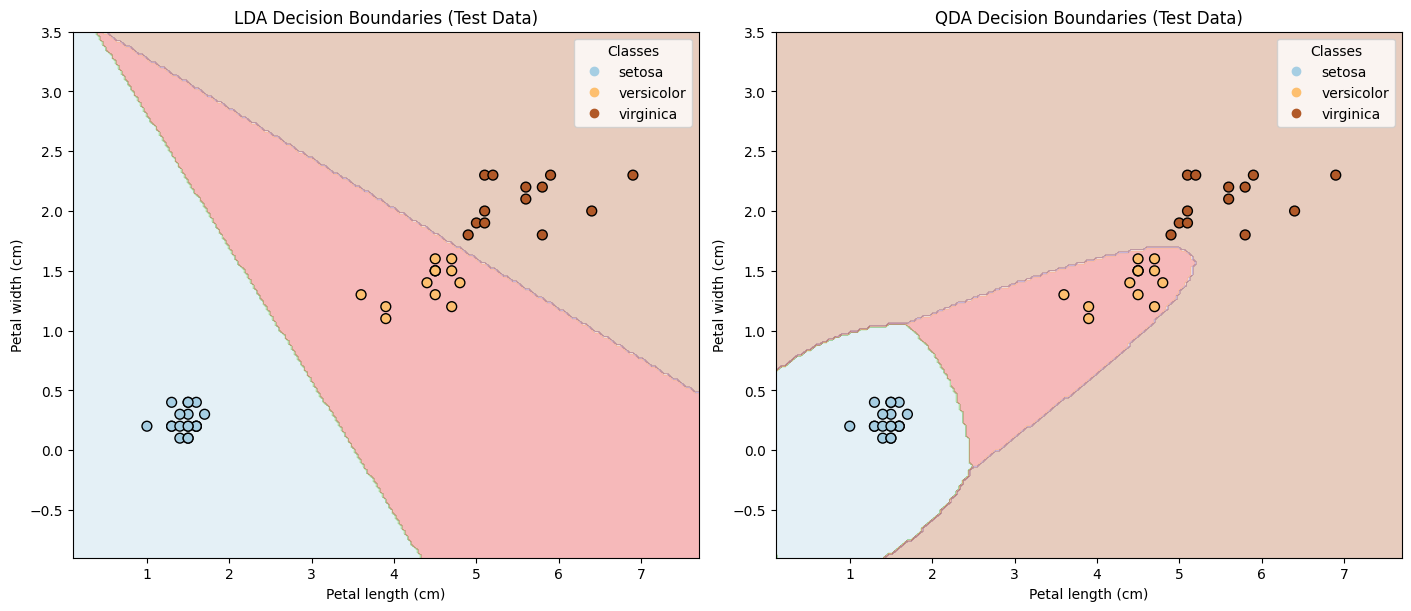

In [215]:
iris = data.load_iris()
X = iris.data
y = iris.target
target_names = iris.target_names

X_plot = X_iris.iloc[:, 2:4]

X_train, X_test, y_train, y_test = train_test_split(X_plot, y, test_size=0.3, random_state=42)

lda = LinearDiscriminantAnalysis()
qda = QuadraticDiscriminantAnalysis()

lda.fit(X_train, y_train)
qda.fit(X_train, y_train)

x_min, x_max = X_train.iloc[:, 0].min() - 1, X_train.iloc[:, 0].max() + 1
y_min, y_max = X_train.iloc[:, 1].min() - 1, X_train.iloc[:, 1].max() + 1
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 200),
                     np.linspace(y_min, y_max, 200))
grid_points = np.c_[xx.ravel(), yy.ravel()]

Z_lda = lda.predict(grid_points).reshape(xx.shape)
Z_qda = qda.predict(grid_points).reshape(xx.shape)

fig, axs = plt.subplots(1, 2, figsize=(14, 6), constrained_layout=True)
cmap = plt.cm.Paired

axs[0].contourf(xx, yy, Z_lda, alpha=0.3, cmap=cmap)
sc0 = axs[0].scatter(X_test.iloc[:, 0], X_test.iloc[:, 1], c=y_test, edgecolor='k', cmap=cmap, marker='o', s=50)
axs[0].set_xlabel("Petal length (cm)")
axs[0].set_ylabel("Petal width (cm)")
axs[0].set_title("LDA Decision Boundaries (Test Data)")
handles0, _ = sc0.legend_elements()
axs[0].legend(handles=handles0, labels=list(target_names), title="Classes")

axs[1].contourf(xx, yy, Z_qda, alpha=0.3, cmap=cmap)
sc1 = axs[1].scatter(X_test.iloc[:, 0], X_test.iloc[:, 1], c=y_test, edgecolor='k', cmap=cmap, marker='o', s=50)
axs[1].set_xlabel("Petal length (cm)")
axs[1].set_ylabel("Petal width (cm)")
axs[1].set_title("QDA Decision Boundaries (Test Data)")
handles1, _ = sc1.legend_elements()
axs[1].legend(handles=handles1, labels=list(target_names), title="Classes")

plt.show()